In [2]:
import os
import numpy as np
import librosa
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import cv2
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# HYPERPARAMETERS
duration_seconds = 4
sample_rate = 44100
hyper_params = {
    'duration': duration_seconds*sample_rate,
     'n_mels': 128,
    'hop_length': 512,
    'n_fft': 2048,
    'fmin': 20,
    'fmax': sample_rate//2
}

In [34]:
def audio_preprocess(file_path):
    waveform, sample_rate = librosa.load(file_path, sr=44100)

    #normalising the waveform since each audio file has the amplitude values in different ranges
    waveform = waveform / np.max(np.abs(waveform))

    #keeping values greater than threshold
    waveform, index = librosa.effects.trim(waveform, top_db=60)

    # keeping values greater than threshold = 0.001
    wav = np.abs(waveform)
    mask = wav > 0.001     # 0.001 is equivalent to a 60db threshold
    waveform = waveform[mask]

    # pad to a length of 4s
    if len(waveform) > hyper_params['duration']:
        waveform = waveform[:hyper_params['duration']]
    else:
        padding = hyper_params['duration'] - len(waveform)
        offset = padding // 2
        waveform = np.pad(waveform, (offset, hyper_params['duration'] - len(waveform) - offset), 'constant')

    return waveform, sample_rate

def compute_mel_spectrogram(audio_file_path, n_fft=2048, hop_length=512, n_mels=128):
    # Load the audio file
    y, sr = audio_preprocess(audio_file_path)

    # Compute the mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = mel_spec_db.astype(np.float32)

    return mel_spec_db


def mono_to_color2(X):
    # Convert single-channel image to three channels
    color_img = cv2.cvtColor(X, cv2.COLOR_GRAY2BGR)

    # Normalize pixel values to the range [0, 255]
    normalized_img = cv2.normalize(color_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return normalized_img

def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    X = np.stack([X, X, X], axis=-1)
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min


    if (_max - _min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [35]:
def save_mel_spectrogram_as_image(mel_spec, output_image_path):
    # Plot the mel spectrogram without axes and color bar
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, hop_length=512, x_axis=None, y_axis=None)
    plt.axis('off')  # Turn off axes

    # Save the mel spectrogram as an image without padding
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close()

In [36]:
def process_label_folder(label_directory, output_label_directory):
    # Loop through each audio file in the label directory
    for audio_file in os.listdir(label_directory):
        audio_file_path = os.path.join(label_directory, audio_file)

        try:
            # Compute mel spectrogram
            mel_spec = compute_mel_spectrogram(audio_file_path)

            # Convert to 3 channels [Better for inputting to CNN model]
            mel_spec = mono_to_color2(mel_spec)

            print(mel_spec.shape)

            output_npz_path = os.path.join(output_label_directory, os.path.splitext(audio_file)[0] + '.npz')
            np.savez(output_npz_path, mel_spec=mel_spec)

            print(f'Saved mel spectrogram array: {output_npz_path}')
        except Exception as e:
            print(f'Error processing {audio_file}: {str(e)}')
            continue



In [37]:
def process_audio_dataset(root_directory, output_directory):
    # Loop through 'train' and 'val' subfolders
    for subfolder in ['train', 'val']:
        subfolder_directory = os.path.join(root_directory, subfolder)

        # Loop through each label folder in the 'train' or 'val' subfolder
        for label in os.listdir(subfolder_directory):
        # for label in ['Laughter', 'Shatter', 'Snare_drum', 'Splash_and_splatter', 'siren']:
            label_directory = os.path.join(subfolder_directory, label)

            # Create a corresponding output subfolder for the label
            output_label_directory = os.path.join(output_directory, subfolder, label)
            os.makedirs(output_label_directory, exist_ok=True)

            # Process audio files in label folder
            process_label_folder(label_directory, output_label_directory)


In [ ]:
def main():
    # Define the root directory containing 'audio_dataset'
    root_directory = '/content/drive/My Drive/audio_dataset/audio_dataset'

    # Define the directory where mel spectrogram images will be saved
    output_directory = '/content/drive/My Drive/DLproject-Numpy/'

    # Process the audio dataset
    process_audio_dataset(root_directory, output_directory)


if __name__ == "__main__":
    main()


(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_1.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_10.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_100.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_101.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_102.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_103.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_104.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_105.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Fart/Fart_106.npz
(128, 345, 3)
Saved mel spectrogram arra

<ipython-input-34-3eed16ec52d2>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=44100)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Laughter/Laughter_99.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/Shatter_1.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/Shatter_10.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/Shatter_100.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/Shatter_101.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/Shatter_102.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/Shatter_103.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/Shatter_104.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Shatter/S

<ipython-input-34-3eed16ec52d2>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=44100)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_134.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_135.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_136.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_137.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_138.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_139.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_14.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Snare_drum/Snare_drum_140.npz
(128, 345, 3)
Saved mel spectrogram array: /conte

<ipython-input-34-3eed16ec52d2>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=44100)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Splash_and_splatter/Splash_and_splatter_103.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Splash_and_splatter/Splash_and_splatter_104.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Splash_and_splatter/Splash_and_splatter_105.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Splash_and_splatter/Splash_and_splatter_106.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Splash_and_splatter/Splash_and_splatter_107.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Splash_and_splatter/Splash_and_splatter_108.npz
(128, 345, 3)
Saved mel spectrogram array: /content/drive/My Drive/DLproject-Numpy/train/Splash_and_splatter/Splash_and_splatter_109.npz
(128, 345, 3)
Saved mel spectrogram array

In [ ]:
data_dir = '/content/drive/My Drive/DLproject/train'
classes1 = os.listdir(data_dir)

In [20]:
def load_and_display_npz(npz_file_path):
    # Load the npz file
    data = np.load(npz_file_path)

    # Extract the mel spectrogram array
    mel_spec = data['mel_spec']

    # mel_spec = Image.fromarray(data['mel_spec'], mode='RGB')
    image = cv2.cvtColor(mel_spec, cv2.COLOR_RGB2BGR)  # Assuming RGB format, adjust accordingly

    # Convert the image back to a NumPy array
    arr_back = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert back to RGB format

    # print(type(image))
    # Display the mel spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(image)
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(label='Amplitude (dB)')
    plt.show()

    return arr_back



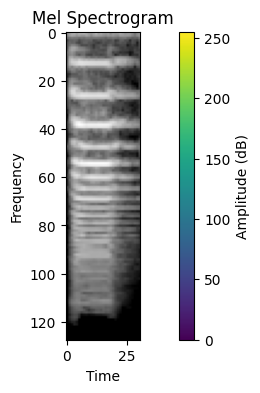

In [21]:
# Example usage
npz_file_path = '/content/drive/My Drive/DLproject-Numpy/augmented_spectograms/car_horn/original_car_horn_1.npz.npz'
mel_spec = load_and_display_npz(npz_file_path)

In [31]:
npz_file_path = '/content/drive/My Drive/DLproject-Numpy/train/car_horn/car_horn_5.npz'
data = np.load(npz_file_path)
# Extract the mel spectrogram array
mel_spec = data['mel_spec']


mel_spec.shape

(128, 345, 3)

In [12]:
type(mel_spec)

numpy.ndarray

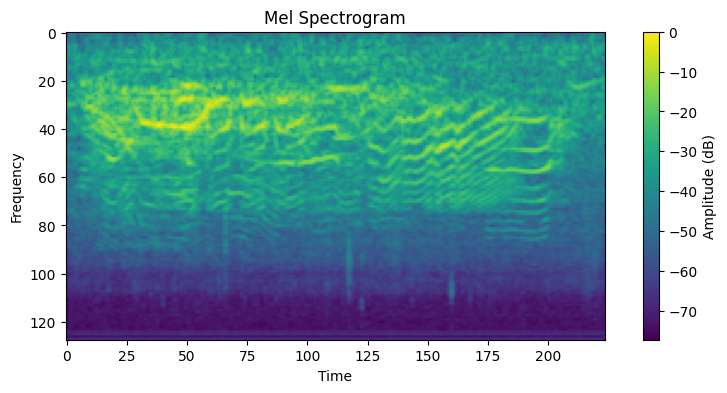

In [ ]:
# Example usage
npz_file_path = '/content/drive/My Drive/DLproject-Numpy/train/Laughter/Laughter_120.npz'
mel_spec = load_and_display_npz(npz_file_path)

In [ ]:
mel_spec.shape

(128, 224)

In [ ]:
mel_spec_normalized = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())

# Expand dimensions to make it a 3D image (height, width, channels)
mel_spec_rgb = np.stack((mel_spec_normalized,) * 3, axis=-1)


In [ ]:
mel_spec_rgb = mono_to_color2(mel_spec)

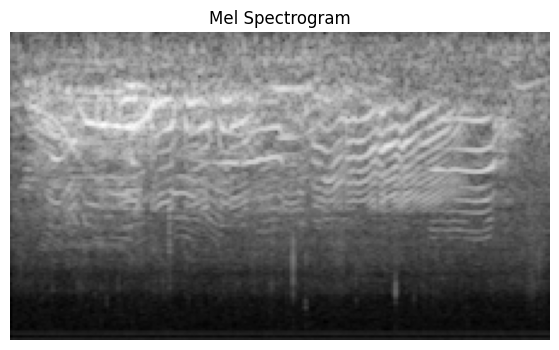

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_rgb)
plt.title('Mel Spectrogram')
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [ ]:
mel_spec_rgb.shape

(128, 224, 3)